In [1]:
import numpy as np
import torch.nn as nn
from PIL import Image
from glob import glob
from tqdm import tqdm_notebook
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms,datasets
import torch.nn.functional as F
import os
import cv2
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


2023-07-20 14:27:39.246180: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 14:27:39.873274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
params = {
    'batch_size':8,
    'num_epoch':200,
    'lr':2e-3,
    'log_dir':'../../data/CycleGANData/wholeslide/',
    'img_form':'tiff'
}

dataLoder

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, imgs,mask,classes, imgsz=(512, 512, 3), transform=None):
        self.th, self.tw, self.tc = imgsz  # target-height, target-width, target-channel
        self.image = imgs
        self.label = mask
        self.category_count=classes
        self.transform = transform
        
    def __getitem__(self, index):
        img = np.array(Image.open(self.image[index]))
        annot = np.array(Image.open(self.label[index]))
        annot = annot.astype(np.float32)
        img = img.astype(np.float32)
        annot  = annot /255.0
        img = img/255.0
        

        
        if annot.ndim == 2:  
            annot = annot[:,:,np.newaxis]
        if img.ndim == 2:  
            img = img[:,:,np.newaxis] 
            
        data = {'input':img, 'label':annot}   
        
        if self.transform:				
            data = self.transform(data)
        
        return data

    def __len__(self):
        return len(self.image)
    
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']
		
        # numpy와 tensor의 배열 차원 순서가 다르다. 
        # numpy : (행, 열, 채널)
        # tensor : (채널, 행, 열)
        # 따라서 위 순서에 맞춰 transpose
        
        label = label.transpose((2, 0, 1)).astype(np.float32) 
        input = input.transpose((2, 0, 1)).astype(np.float32)
		
        # 이후 np를 tensor로 바꾸는 코드는 다음과 같이 간단하다.
        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data
    
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

In [4]:
imgs=glob('../../data/CycleGANData/wholeslide/image/*.'+params['img_form'])
masks=[f.replace('/image', '/mask') for f in imgs]
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
dataset = CustomDataset(imgs=imgs,mask=masks,classes=1,transform=transform)
train_size = int(len(dataset) * 0.8)
validation_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
loader_train = DataLoader(train_dataset, batch_size =params['batch_size'], shuffle=True)
loader_validation = DataLoader(validation_dataset, batch_size = params['batch_size'], shuffle=True)
loader_test = DataLoader(test_dataset, batch_size = params['batch_size'], shuffle=True)

Network

In [5]:
## 네트워크 구축
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=3, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [6]:
net = UNet().to(device)

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice 
fn_loss = DiceLoss().to(device)
# Optimizer 정의
optim = torch.optim.Adam(net.parameters(),lr = params['lr'] ) 

# 기타 variables 설정
num_train = len(train_dataset)
num_val = len(validation_dataset)

num_train_for_epoch = np.ceil(num_train/params['batch_size']) # np.ceil : 소수점 반올림
num_val_for_epoch = np.ceil(num_val/params['batch_size'])

# 기타 function 설정
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1) # device 위에 올라간 텐서를 detach 한 뒤 numpy로 변환
fn_denorm = lambda x, mean, std : (x * std) + mean 
fn_classifier = lambda x :  1.0 * (x > 0.5)  # threshold 0.5 기준으로 indicator function으로 classifier 구현


In [ ]:
validation_optimization_loss=2
train_loss_list=[]
validation_loss_list=[]
for epoch in range(params['num_epoch']):
    net.train()
    loss_arr = []
    validation_losses=[]
    ae=tqdm_notebook(loader_train)
    for batch, data in enumerate(ae): # 1은 뭐니 > index start point
        # forward
        label = data['label'].to(device)   # 데이터 device로 올리기     
        inputs = data['input'].to(device)
        output = net(inputs) 

        # backward
        optim.zero_grad()  # gradient 초기화
        loss = fn_loss(output,label)  # output과 label 사이의 loss 계산
        loss.backward() # gradient backpropagation
        optim.step() # backpropa 된 gradient를 이용해서 각 layer의 parameters update

        # save loss
        loss_arr += [loss.item()]

        # tensorbord에 결과값들 저정하기
        label = fn_tonumpy(label)
        inputs = fn_tonumpy(fn_denorm(inputs,0.5,0.5))
        output = fn_tonumpy(fn_classifier(output))
        ae.set_description(f"epoch: {epoch+1}/{params['num_epoch']} loss :{loss.item():.4f}") 
         
    #validatoin
    
    for batch, data in enumerate(loader_validation): # 1은 뭐니 > index start point
        # forward
        label = data['label'].to(device)   # 데이터 device로 올리기     
        inputs = data['input'].to(device)
        output = net(inputs) 

  
        loss = fn_loss(output,label)  # output과 label 사이의 loss 계산
        # save loss
        validation_losses += [loss.item()]
    print(f"Train loss: {np.array(loss_arr).mean():.4f} val_loss: {np.array(validation_losses).mean():.4f}")
    train_loss_list.append(np.array(loss_arr).mean())
    validation_loss_list.append(np.array(validation_losses).mean())
    if validation_optimization_loss>=np.array(validation_losses).mean():
        validation_optimization_loss=np.array(validation_losses).mean()
        torch.save(net,'../../model/seg/optimization_loss.pt')
    fig = plt.figure()
    rows = 1
    cols = 3
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(inputs[0].to('cpu').transpose(2,0))
    ax1.set_title('img')
    ax1.axis("off")
    
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(label[0].to('cpu').transpose(2,0))
    ax2.set_title('ground_truth')
    ax2.axis("off")   
    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(F.sigmoid(output[0]).to('cpu').transpose(2,0).detach().numpy())
    ax3.set_title('pred')
    ax3.axis("off") 
    plt.show()

In [48]:
test_losses=[]
count=0
for batch, data in enumerate(loader_test): # 1은 뭐니 > index start point
        
        label = data['label'].to(device)   # 데이터 device로 올리기     
        inputs = data['input'].to(device)
                
        output = net(inputs) 
        loss = fn_loss(output,label)  # output과 label 사이의 loss 계산
        for i in range(8):
            output_img=F.sigmoid(output[i]).to('cpu').transpose(2,0).detach().numpy()
            output_img=np.where(output_img>=0.5,255,0).astype(np.int16)
            label_img=label[i].to('cpu').transpose(2,0).detach().numpy()*255
            label_img=label_img.astype(np.int16)
            inputs_img=inputs[i].to('cpu').transpose(2,0).detach().numpy()*255
            inputs_img=inputs_img.astype(np.float32)
            cv2.imwrite('../../data/segmentation/pred/'+str(count)+'.png', output_img) 
            cv2.imwrite('../../data/segmentation/mask/'+str(count)+'.png', label_img) 
            cv2.imwrite('../../data/segmentation/image/'+str(count)+'.png', cv2.cvtColor(inputs_img, cv2.COLOR_BGR2RGB)) 
            count+=1
            
            # save loss
        test_losses += [loss.item()]

IndexError: index 2 is out of bounds for dimension 0 with size 2

True

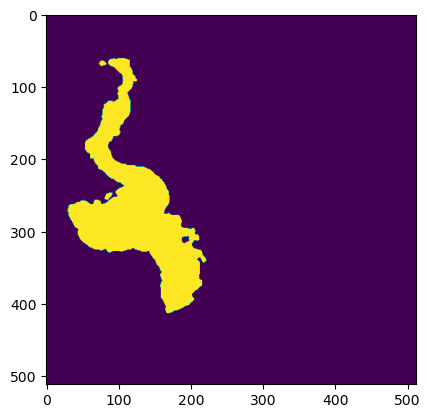

In [40]:

output_img=F.sigmoid(output[0]).to('cpu').transpose(2,0).detach().numpy()
output_img=np.where(output_img>=0.5,255,0).astype(np.int16)
plt.imshow(output_img)
cv2.imwrite('sample_out_2.png', cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))  

In [47]:
cv2.cvtColor(inputs_img, cv2.COLOR_BGR2RGB)

error: OpenCV(4.6.0) /croot/opencv-suite_1676452025216/work/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 3 (CV_16S)
